# Install Dependencies

This notebook was used to specifically test experiments for the Alternating Variant of the Mixture Model. In this notebook, we create a Mixture Model composed of a Convolutional Network and Vision Transformer combined into a block. The results of the experiment are shown in a table and plots. 

In [ ]:
!pip install vit-pytorch
!pip install tabulate

# Datasets

* CIFAR-10

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

def DataLoaders(dataset = "CF-10", data_root = "./", batch_size = 16):
  transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.5, hue = 0.25),
        transforms.ToTensor(),
      ])

  transform_test = transforms.Compose([
      transforms.ToTensor(),
  ])
  root_dir = os.path.join(data_root, dataset)
  if dataset == "CF-10":
    train_dataset = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
  
    return train_loader, test_loader 

In [ ]:
def GetNumberParameters(model):
  return sum(np.prod(p.shape).item() for p in model.parameters())

In [ ]:
def save_model(model, file_name):
    from torch import save
    from os import path
    print("saving", file_name)
    return save(model.state_dict(), file_name)


def load_model():
    from torch import load
    from os import path
    r = CNNClassifier()
    r.load_state_dict(load(path.join(path.dirname(path.abspath(__file__)), 'cnn.th'), map_location='cpu'))
    return r

In [ ]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

In [ ]:
train_loader, test_loader = DataLoaders("CF-10", batch_size = 128)

# Model Architecture

## Alternating Variant

In [ ]:
from vit_pytorch import ViT
import torchvision
from vit_pytorch import ViT
import torchvision.models as models

class MMBlock(torch.nn.Module):
  def __init__(self, image_size = 32, num_labels = 10, depth = 1, att_heads = 1, mlp_dim = 2048, output_dim = 1024):
    super().__init__()
    self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 15, stride = 2, padding = 2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 3, kernel_size=4, stride=3, padding=1),
            torch.nn.BatchNorm2d(3)
    )

    self.vision_transformer = ViT(
        image_size = image_size,
        patch_size = image_size // 16,
        num_classes = num_labels,
        dim = output_dim,
        depth = depth,
        heads = att_heads,
        mlp_dim = mlp_dim,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    self.vision_transformer = torch.nn.Sequential(*(list(self.vision_transformer.children())[:-1]))

    self.upsample_vit = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 3, kernel_size=3, stride=1, padding = 1),
            torch.nn.BatchNorm2d(3))

  def forward(self, x):
    res = self.conv_net(x)
    res = self.vision_transformer(res)
    res = res[:, :, :, None]
    dim = int(res.shape[2] ** 0.5)
    res = res.view(res.shape[0], res.shape[1], dim, dim)

    return self.upsample_vit(res)

class AlternatingMixtureModel(torch.nn.Module):
    def __init__(self, num_blocks = 1, image_size = 32, num_labels = 10, depth = 1, att_heads = 1, mlp_dim = 2048, output_dim = 1024):
        super().__init__()
        self.blocks =  []
        for i in range(num_blocks):
            self.blocks.append(MMBlock(image_size = image_size, num_labels = num_labels, depth = depth, att_heads = att_heads, mlp_dim = mlp_dim, output_dim = output_dim))
        self.ffn = torch.nn.Linear(3 * 32 * 32, 10)
        self.MM = torch.nn.Sequential(*self.blocks)
      
    def forward(self, x):
      return self.ffn(self.MM(x).flatten(start_dim = 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlternatingMixtureModel(2).to(device)
img = torch.randn(16, 3, 32, 32).to(device)
print(model(img).shape)

torch.Size([16, 10])


# Alternating Variant with Residual Connections

In [ ]:
class ResidualCNNBlock(torch.nn.Module):
    def __init__(self, c_in, c_out, should_stride=False):
        super().__init__()

        if should_stride:
            stride = 2
        else:
            stride = 1

        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(c_in, c_out, 3, padding=1, stride=stride),
            torch.nn.BatchNorm2d(c_out),
        ) 
        
        self.relu = torch.nn.ReLU()

        if c_in != c_out or should_stride:
            self.identity = torch.nn.Conv2d(c_in, c_out, 1, stride=stride)
        else:
            self.identity = lambda x: x

    def forward(self, x):
        result = self.block(x)
        x = self.identity(x)

        return self.relu(x + result)

class ResMMBlock(torch.nn.Module):
  def __init__(self, image_size = 32, num_labels = 10, depth = 1, att_heads = 1, mlp_dim = 2048, output_dim = 1024):
    super().__init__()
    self.conv_net = torch.nn.Sequential(
              ResidualCNNBlock(3, 32, False),
              ResidualCNNBlock(32, 32, False),
              ResidualCNNBlock(32, 128, False),
              ResidualCNNBlock(128, 128, False),
              ResidualCNNBlock(128, 3, False)
    )
    self.vision_transformer = ViT(
        image_size = image_size,
        patch_size = image_size // 16,
        num_classes = num_labels,
        dim = output_dim,
        depth = depth,
        heads = att_heads,
        mlp_dim = mlp_dim,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    self.vision_transformer = torch.nn.Sequential(*(list(self.vision_transformer.children())[:-1]))

    self.upsample_vit = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 3, kernel_size=3, stride=1, padding = 1),
            torch.nn.BatchNorm2d(3))

  def forward(self, x):
    res = self.conv_net(x)
    res = self.vision_transformer(res)
    res = res[:, :, :, None]
    dim = int(res.shape[2] ** 0.5)
    res = res.view(res.shape[0], res.shape[1], dim, dim)

    return self.upsample_vit(res)

class ResAlternatingMixtureModel(torch.nn.Module):
    def __init__(self, num_blocks = 1, image_size = 32, num_labels = 10, depth = 1, att_heads = 1, mlp_dim = 2048, output_dim = 1024):
        super().__init__()
        self.blocks =  []
        for i in range(num_blocks):
            self.blocks.append(ResMMBlock(image_size = image_size, num_labels = num_labels, depth = depth, att_heads = att_heads, mlp_dim = mlp_dim, output_dim = output_dim))
        self.ffn = torch.nn.Linear(3 * 32 * 32, 10)
        self.MM = torch.nn.Sequential(*self.blocks)
      
    def forward(self, x):
      return self.ffn(self.MM(x).flatten(start_dim = 1))

class ConvNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_net = torch.nn.Sequential(
              ResidualCNNBlock(3, 32, False),
              ResidualCNNBlock(32, 32, False),
              ResidualCNNBlock(32, 128, False),
              ResidualCNNBlock(128, 128, False),
              ResidualCNNBlock(128, 3, False)
    )
    self.ffn = torch.nn.Linear(3 * 32 * 32, 10)

  def forward (self, x):
    return self.ffn(self.conv_net(x).flatten(start_dim = 1))

model = ConvNet()
print(model(torch.rand(16, 3, 32, 32)).shape)

torch.Size([16, 10])


## Joint Variant

In [ ]:
class JointMixtureModel(torch.nn.Module):
    def __init__(self, num_blocks = 1, image_size = 32, num_labels = 10, depth = 1, att_heads = 1, mlp_dim = 2048, output_dim = 1024):
      super().__init__()
      self.blocks = []
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      for i in range(num_blocks):
        conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(3, image_size, 15, stride = 2, padding = 2),
            torch.nn.BatchNorm2d(image_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(image_size, image_size, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(image_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(image_size, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 3, stride = 1, padding = 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 3, kernel_size=4, stride=3, padding=1),
            torch.nn.BatchNorm2d(3)
        )
        vit = ViT(
          image_size = image_size,
          patch_size = image_size // 16,
          num_classes = num_labels,
          dim = output_dim,
          depth = depth,
          heads = att_heads,
          mlp_dim = mlp_dim,
          dropout = 0.1,
          emb_dropout = 0.1
        )
        vit = torch.nn.Sequential(*(list(vit.children())[:-1]))

        upsample_vit = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 3, kernel_size=3, stride=1, padding = 1),
            torch.nn.BatchNorm2d(3))
        conv_net = conv_net.to(device)
        vit = vit.to(device)
        upsample_vit = upsample_vit.to(device)
        self.blocks.append([conv_net, vit, upsample_vit])

      self.ffn = torch.nn.Linear(3 * 32 * 32, 10)

    def forward(self, x):
        input = x
        for conv_net, vit, upsample in self.blocks:
          res1 = conv_net(input)
          res2 = vit(input)
          res2 = res2[:, :, :, None]
          dim = int(res2.shape[2] ** 0.5)
          res2 = res2.view(res2.shape[0], res2.shape[1], dim, dim)
          res2 = upsample(res2)

          input = res1 + res2
        
        return self.ffn(input.flatten(start_dim = 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JointMixtureModel(2).to(device)
# img = torch.randn(16, 3, 32, 32).to(device)
# print(model(img).shape)
print(model)
GetNumberParameters(model)

JointMixtureModel(
  (ffn): Linear(in_features=3072, out_features=10, bias=True)
)


30730

# Training Code

In [ ]:
lr = 1e-3
epochs = 15
batch_size = 128
num_workers = 2
weight_decay = 1e-4
# Set up the cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = JointMixtureModel(1).to(device)
# model = models.resnet18(pretrained=False).to(device)
# model = ResAlternatingMixtureModel(num_blocks=1, depth = 2, att_heads=2)
# model = ConvNet()

model = ViT(
        image_size = 32,
        patch_size = 32 // 16,
        num_classes = 10,
        dim = 1024,
        depth = 2,
        heads = 2,
        mlp_dim = 2048,
        dropout = 0.1,
        emb_dropout = 0.1
    )

print(GetNumberParameters(model))
model.load_state_dict(torch.load('vit75.th', map_location='cpu'))
model = model.to(device)

# Set up loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

# Set up training data and validation data
data_train, data_val = DataLoaders("CF-10", batch_size = batch_size)

# Set up loggers
# log_dir = '.'
# log_time = '{}'.format(time.strftime('%H-%M-%S'))
# log_name = 'lr=%s_epoch=%s_batch_size=%s_wd=%s' % (lr, epochs, batch_size, weight_decay)
# logger = tb.SummaryWriter()
# train_logger = tb.SummaryWriter(path.join(log_dir, 'train') + '/%s_%s' % (log_name, log_time))
# valid_logger = tb.SummaryWriter(path.join(log_dir, 'test') + '/%s_%s' % (log_name, log_time))
# global_step = 0

# Wrap in a progress bar.
for epoch in range(epochs):
    # print("!!!!!!!!!!!!!!EPOCH {}!!!!!!!!!!!!!".format(epoch))
    # Set the model to training mode.
    model.train()

    train_accuracy_val = list()
    for x, y in tqdm(data_train):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        train_accuracy_val.append(accuracy(y_pred, y))

        # Compute loss and update model weights.
        loss = loss_func(y_pred, y)

        loss.backward()
        optim.step()
        optim.zero_grad()
        
        # Add loss to TensorBoard.
        # train_logger.add_scalar('Loss', loss.item(), global_step=global_step)
        # global_step += 1

    train_accuracy_total = torch.FloatTensor(train_accuracy_val).mean().item()
    # train_logger.add_scalar('Train Accuracy', train_accuracy_total, global_step=global_step)
    print("Train Accuracy: {:.4f}".format(train_accuracy_total))

    if epoch % 2 == 0:
      save_model(model, 'det128_' + str(epoch) + '.th')

    # Set the model to eval mode and compute accuracy.
    # No need to change this, but feel free to implement additional logging.
    model.eval()

    accuracys_val = list()

    for x, y in data_val:
        x = x.to(device)
        y = y.to(device)  
        y_pred = model(x)
        accuracys_val.append(accuracy(y_pred, y))
 
    accuracy_total = torch.FloatTensor(accuracys_val).mean().item()
    print("Validation Accuracy: {:.4f}".format(accuracy_total))
    # valid_logger.add_scalar('Validation Accuracy', accuracy_total, global_step=global_step)


# Results

In [3]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Training Time - 3.5 Hours
alternating_train = [0.3460, 0.4814, 0.5392, 0.5796, 0.6112, 0.6317, 0.6498, 0.6636, 0.6767, 0.6873, 0.6987, 0.7072, 0.7143, 0.7185, 0.7363, 0.7574, 0.7654, 0.7697, 0.7741, 0.7784, 0.7823, 0.7837, 0.7899, 0.7897, 0.7952, 0.7958, 0.8000, 0.8028, 0.8044, 0.8068]
alternating_val =   [0.4508, 0.5146, 0.5618, 0.6039, 0.6403, 0.6510, 0.6603, 0.6749, 0.7004, 0.6987, 0.7125, 0.7028, 0.6819, 0.7281, 0.7237, 0.7448, 0.7572, 0.7534, 0.7389, 0.7671, 0.7710, 0.7533, 0.7543, 0.7647, 0.7731, 0.7701, 0.7988, 0.7729, 0.7783, 0.7739]

# Training Time - 24 Minutes
resnet18_train =    [0.4416, 0.6000, 0.6605, 0.7019, 0.7274, 0.7457, 0.7679, 0.7801, 0.7930, 0.8052, 0.8168, 0.8244, 0.8378, 0.8447, 0.8552, 0.8571, 0.8696, 0.8744, 0.8829, 0.8885, 0.8942, 0.8986, 0.9014, 0.9082, 0.9122, 0.9171, 0.9163, 0.9181, 0.9273, 0.9267]
resnet18_val   =    [0.4323, 0.6299, 0.5923, 0.6545, 0.7077, 0.6743, 0.7096, 0.7310, 0.7203, 0.6823, 0.7497, 0.7206, 0.7609, 0.7618, 0.7568, 0.7738, 0.7618, 0.7714, 0.7742, 0.7678, 0.7411, 0.7782, 0.7877, 0.7632, 0.7744, 0.7705, 0.7758, 0.7898, 0.7663, 0.7643]

# Training Time - 56 Minutes
conv_net_train =    [0.4112, 0.5449, 0.5886, 0.6155, 0.6364, 0.6512, 0.6671, 0.6775, 0.6876, 0.6943, 0.6994, 0.7115, 0.7165, 0.7223, 0.7290, 0.7340, 0.7395, 0.7458, 0.7531, 0.7551, 0.7635, 0.7674, 0.7701, 0.7729, 0.7781, 0.7825, 0.7869, 0.7901, 0.7915, 0.7994]
conv_net_val   =    [0.4741, 0.5763, 0.6090, 0.6274, 0.6399, 0.6457, 0.6320, 0.6406, 0.6677, 0.6671, 0.6709, 0.6794, 0.6850, 0.6679, 0.6631, 0.6782, 0.6782, 0.6742, 0.6881, 0.6800, 0.6721, 0.6799, 0.6787, 0.6868, 0.6643, 0.6818, 0.6855, 0.6774, 0.6791, 0.6709]

# Training Time - About 6 Hours!
vit_train      =    [0.2052, 0.2709, 0.2850, 0.3179, 0.3614, 0.4153, 0.4812, 0.5354, 0.5735, 0.6017, 0.6154, 0.6388, 0.6495, 0.6465, 0.6508, 0.6551, 0.6530, 0.6670]
vit_val        =    [0.2230, 0.3040, 0.3185, 0.3673, 0.3973, 0.4401, 0.5100, 0.5496, 0.5987, 0.6016, 0.6176, 0.6432, 0.6377, 0.6492, 0.6300, 0.6416, 0.6506, 0.6486]



In [13]:
# cRT Training Approach Results
# Batch size = 128, learning rate = 1e-3, epochs = 10, ResNeXT Backbone Network
table = [['Model', 'Top-1 Test Accuracy', 'Total Training Time (Minutes)', 'Epochs', 
         'Number of Parameters', 'GPU', 'Batch Size'], 
         ['ResNet-18 (Baseline)', 0.7898, 24, 30, 11689512, "NVIDIA Tesla K80", 128], 
         ['1 Block Alternating MM (Conv + ViT) ', 0.7988, 210, 30, 9708095, "NVIDIA Tesla K80", 128], 
         ['Convolutional NN w/ Residual Connections', 0.6881, 56, 30, 234294, "NVIDIA Tesla K80", 128], 
         ['VIT (2-depth, 2-attention-head)', 0.6506, 360, 85, 9743370, "NVIDIA Tesla K80", 128],
         ['2 Block Joint MM (Conv + ViT)', 0.3018, 153, 50, 19416190, "NVIDIA GeForce RTX 3070 Laptop GPU", 32], 
         ['VIT (2-depth, 4-attention-head)', 0.5614, 78, 50, 10791946, "NVIDIA GeForce RTX 3070 Laptop GPU", 64], 
         ['1 Block Joint MM (Conv + ViT)', 0.3787, 70, 50, 9708095, "NVIDIA GeForce RTX 3070 Laptop GPU", 64]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════════════╤═══════════════════════╤═════════════════════════════════╤══════════╤════════════════════════╤════════════════════════════════════╤══════════════╕
│ Model                                    │   Top-1 Test Accuracy │   Total Training Time (Minutes) │   Epochs │   Number of Parameters │ GPU                                │   Batch Size │
╞══════════════════════════════════════════╪═══════════════════════╪═════════════════════════════════╪══════════╪════════════════════════╪════════════════════════════════════╪══════════════╡
│ ResNet-18 (Baseline)                     │                0.7898 │                              24 │       30 │               11689512 │ NVIDIA Tesla K80                   │          128 │
├──────────────────────────────────────────┼───────────────────────┼─────────────────────────────────┼──────────┼────────────────────────┼────────────────────────────────────┼──────────────┤
│ 1 Block Alternating MM (Conv + ViT)      │ 

Text(0, 0.5, 'Top-1 Accuracy')

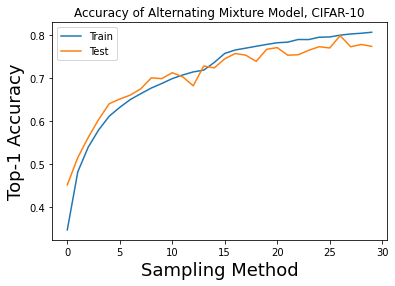

In [7]:
# Display Mixture Model Results
plt.plot(alternating_train)
plt.plot(alternating_val)
plt.legend(["Train", "Test"])
plt.title("Accuracy of Alternating Mixture Model, CIFAR-10")
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)

Text(0, 0.5, 'Top-1 Accuracy')

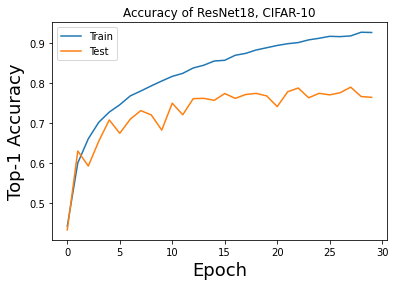

In [8]:
# Display ResNet18 Results
plt.plot(resnet18_train)
plt.plot(resnet18_val)
plt.legend(["Train", "Test"])
plt.title("Accuracy of ResNet18, CIFAR-10")
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)

Text(0, 0.5, 'Top-1 Accuracy')

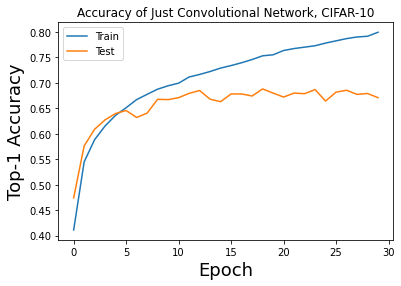

In [9]:
# Display Results when Only use Convolutional Network of Mixture Model
plt.plot(conv_net_train)
plt.plot(conv_net_val)
plt.legend(["Train", "Test"])
plt.title("Accuracy of Just Convolutional Network, CIFAR-10")
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)

Text(0, 0.5, 'Top-1 Accuracy')

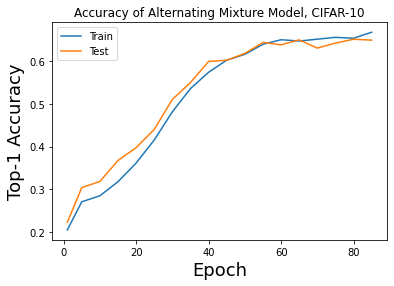

In [19]:
# Display Results when Only use Vision Transformer of Mixture Model
plt.plot([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85], vit_train)
plt.plot([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85], vit_val)
plt.legend(["Train", "Test"])
plt.title("Accuracy of Alternating Mixture Model, CIFAR-10")
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Top-1 Accuracy', fontsize = 18)